### Problem 6.6

In this method we will use the Lax-Friedrichs method for solving the velocity-stress formulation: 

$$ 
v_j^{n+1} = \frac{1}{2} \left( v_{j+1}^n + v_{j-1}^n \right) + \frac{\Delta t}{\rho_j} \frac{\sigma_{j+1}^n - \sigma_{j-1}^n}{2\, \Delta x} \\ 
\sigma_j^{n+1} = \frac{1}{2} \left( \sigma^n_{j+1} + \sigma^n_{j-1} \right) + \Delta t \, \mu_j \frac{v^n_{j+1} - v_{j-1}^n}{2\, \Delta x} \quad.
$$ 

First let us define our domain: 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from copy import copy

# Domain parameters
L  = 100
dx = 0.1

# 1D Array holding grid points, x
x = np.arange(0, L+dx, dx)

# Number of grid points in x
N = len(x)

# Velocity (v) and stress (sigma)
v     = np.zeros(N)
sigma = np.zeros(N)

v_new = np.zeros(N)
s_new = np.zeros(N)

# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

### CFL condition and initial condition

In [2]:
beta = np.sqrt(np.max(mu)/np.min(rho))
C = 0.5
dt = dx * C / beta

In [3]:
def apply_initial_condition(x, v, sigma):
    # Equation 6.44
    sigma[:] = 0
    v = -0.2 * (x-50) * np.exp(-0.1*(x-50)**2)
    return v, sigma

### Solver

We now define the solver that iterates in time. Unlike in Problem 6.4, this formalisation only relies on the current timestep.

In [4]:
def Lex_step_in_time(s, s_new, v, v_new, dx, dt, mu, rho, use_Dirichlet_BC):
    # Notes on slicing:
    # [1:-1] includes all points except boundaries
    # [2:  ] is from 3rd to end
    # [:-2 ] is from start to 3rd-last (missing last two points)

    # [1:-1] represents lower index = j
    # [2:  ] represents lower index = j + 1
    # [:-2 ] represents lower index = j - 1

    # Variable names (s and v):
    # s for sigma, v for v (velocity)
    # ? below means s or v
    # ?_new  represents superscript = n + 1
    # ?      represents superscript = n

    # Compute new v and s
    v_new[1:-1] = 0.5*(v[2:]+v[:-2]) + (dt / (2* rho[1:-1] * dx) ) * (s[2:] - s[:-2])
    
    s_new[1:-1] = 0.5*(s[2:]+s[:-2]) + (dt * mu[1:-1] / (2*dx) ) * (v[2:] - v[:-2])

    # Apply boundary conditions:
    if use_Dirichlet_BC:
        # Dirichlet:
        v_new[0]  = 0
        v_new[-1] = 0

        # Use a 1-sided gradient approximation for the edges:
        s_new[0]  = s[0]  +  dt * mu[0]  * v[1] / dx
        s_new[-1] = s[-1] +  dt * mu[-1] * -v[-2] / dx
    else:
        s_new[0]  = 0
        s_new[-1] = 0

        v_new[0]  = v[0]  + dt *   s[1] / (dx * rho[0])
        v_new[-1] = v[-1] + dt * -s[-2] / (dx * rho[-1])

    return  v_new, s_new

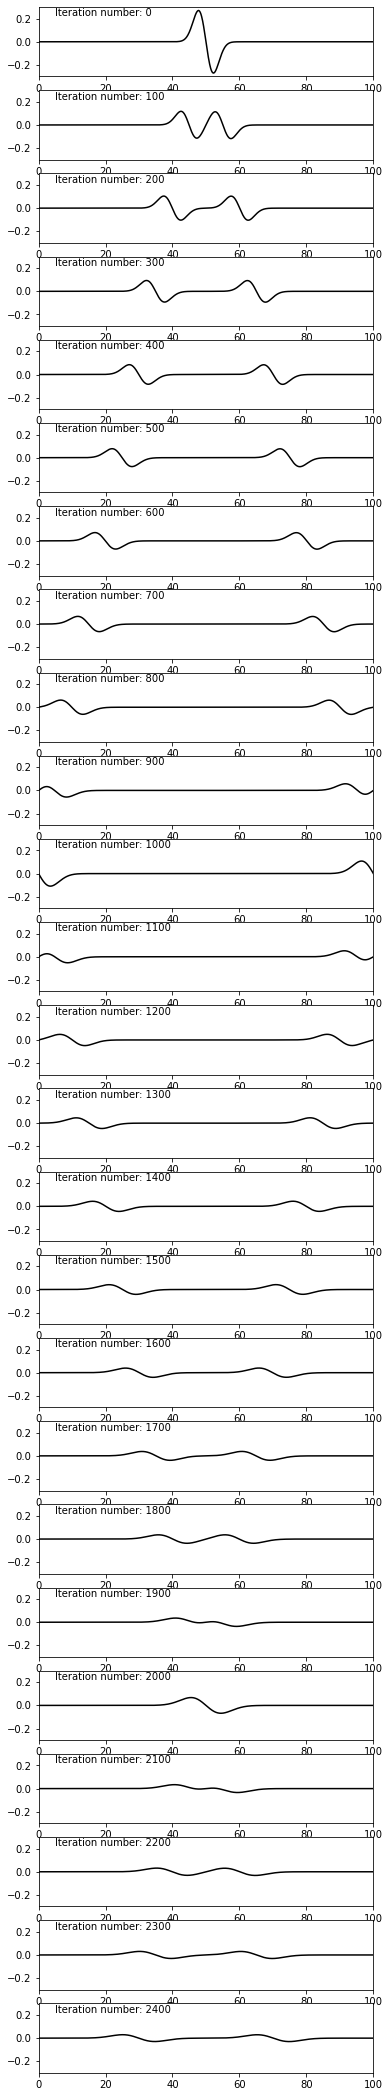

In [5]:
# Apply initial conditions
v, sigma     = apply_initial_condition(x, v, sigma)

# Number of timesteps and steps to plot
nsteps     = 2500
plot_every = 100
nplots     = nsteps//plot_every


# Create Figure
fig, ax = plt.subplots(nplots, figsize=(6,38))
iax = 0 

# Iterate through timesteps 
for i in range(nsteps):
    v_new, s_new = Lex_step_in_time(s=sigma, s_new=s_new,
                                    v=v, v_new=v_new,
                                    dx=dx, dt=dt, mu=mu, rho=rho,
                                    use_Dirichlet_BC=True)
    # Update timestep
    sigma = copy(s_new)
    v     = copy(v_new)


    if i%plot_every==0:
        ax[iax].plot(x, v, 'k')
        
        ax[iax].text(x=5, y = 0.22, s=f"Iteration number: {i}")
        ax[iax].set_xlim([0,100])
        ax[iax].set_ylim([-0.3,0.3])

        iax += 1


### Inhomogeneous Domain

Let us now consider the case of an inhomogeneous domain in which the shear modulus changes from $\mu = 1$ for $x \in [0,\,65]$ to $\mu = 4$ for $x \in [65,\,100]$.

In [6]:
# Velocity (v) and stress (sigma)
v     = np.zeros(N)
sigma = np.zeros(N)

v_new = np.zeros(N)
s_new = np.zeros(N)

# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

# For the region where x is greater than 65 we will now edit the shear values: 
mu[x > 65] = 4

Since we have changed our domain, we need to update our CFL condition and timestep

In [7]:
# We also need to update our CFL condition: 
beta = np.sqrt(np.max(mu)/np.min(rho))
C = 0.5
dt = dx * C / beta

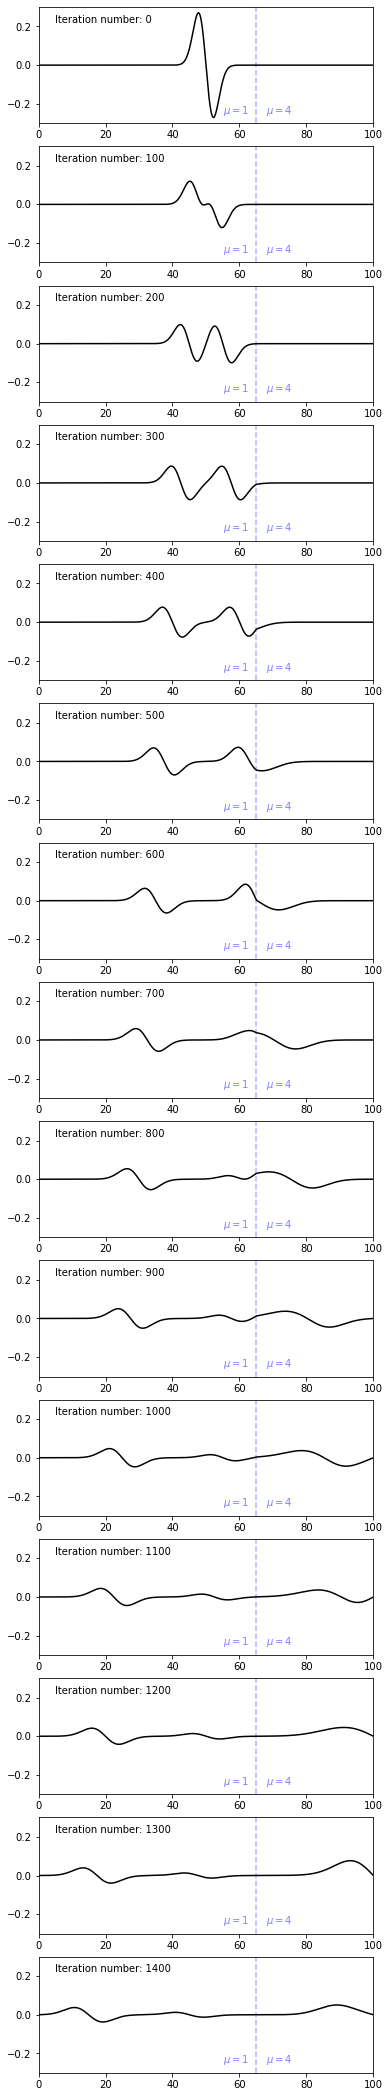

In [8]:
# Apply initial conditions
v, sigma     = apply_initial_condition(x, v, sigma)

# Number of timesteps and steps to plot
nsteps     = 1500
plot_every = 100
nplots     = nsteps//plot_every

# Create Figure
fig, ax = plt.subplots(nplots, figsize=(6,38))
iax = 0 

# Iterate through timesteps 
for i in range(nsteps):
    v_new, s_new = Lex_step_in_time( s=sigma, s_new=s_new,
                                       v=v, v_new=v_new,
                                       dx=dx, dt=dt, mu=mu, rho=rho,
                                       use_Dirichlet_BC=True)
    # Update timestep
    v     = copy(v_new)
    sigma = copy(s_new)

    if i%plot_every==0:
        
        # Plot a line at x=65 and add annotation
        ax[iax].axvline(65, alpha=0.3, linestyle='--', color='blue')
        ax[iax].text(x=55, y = -0.25, s=r"$\mu = 1$", color='blue', alpha=0.5)
        ax[iax].text(x=68, y = -0.25, s=r"$\mu = 4$", color='blue', alpha=0.5)

        ax[iax].plot(x, v, 'k')
        
        ax[iax].text(x=5, y = 0.22, s=f"Iteration number: {i}")
        ax[iax].set_xlim([0,100])
        ax[iax].set_ylim([-0.3,0.3])

        
        iax += 1
